# Active Fire Detection

As wildfires sweep through California we wanted to find ways to leverage DigitalGlobe imagery in a way that might help with the response. Our first thought was to find some imagery of the affected areas and calculate a burn index. However, as the fires are still extremely active the visible and near-infrared bands of the Worldview2 and Worldview3 sensors are inhibited by heaving amounts of smoke. However, Worldview3 provides a series of Shortwave-Infrared bands that can be used to see through smoke. 

In this notebook we explore the usage of SWIR imagery to identify and extract active fires from an image. This type of analysis could be used to aid response efforts while fires are still active, and help to identify priority areas for firefighters as soon as imagery become available.


## Finding images

The first step in any image analysis is finding imagery. To do this we search the Digitalglobe catalog for a series the types of imagery we're interested in working with. In this case we want to find images of type `WV03_VNIR` and `WV03_SWIR`. To do this we make a query for all of the already available imagery within an AOI new Ventura, CA. 

In [1]:
import time
import json
from shapely.geometry import box
from gbdxtools import Interface
gbdx = Interface()

bbox = [-119.3187, 34.4768, -119.2758, 34.506]

aoi = box(*bbox).wkt
query = "(item_type:WV03_VNIR OR item_type:WV03_SWIR)"
query += " AND NOT item_type:IDAHOImage AND item_type:DigitalGlobeProduct"   
results = gbdx.vectors.query(aoi, query)
    
for r in results:
    props = r['properties']
    print props['attributes']['catalogID'], props['item_date'][0:10], props['item_type'][1]

104A01003636D300 2017-12-07 WV03_SWIR
104001001CAB3500 2016-05-26 WV03_VNIR
104001001CAB3500 2016-05-26 WV03_VNIR
104001003AB04D00 2018-02-26 WV03_VNIR
1040010040C6E100 2018-08-08 WV03_VNIR
1040010039B88D00 2018-02-26 WV03_VNIR
104001003AB04D00 2018-02-26 WV03_VNIR
1040010039B88D00 2018-02-26 WV03_VNIR
1040010039B88D00 2018-02-26 WV03_VNIR
1040010039B88D00 2018-02-26 WV03_VNIR
1040010040C6E100 2018-08-08 WV03_VNIR


## Initialize CatalogImages

From the list above we can see that we've found several images that match our AOI. For the sake of this notebook we'll select 2 catalog IDs from the list, one VNIR and one SWIR. This will let us explore the visible wavelengths of the VNIR data as well as the non-visible bands available in the SWIR data. 

In [2]:
from gbdxtools.task import env
from gbdxtools import CatalogImage

vnir_id = env.inputs.get('vnir_id', '104001003636D300')

vnir = CatalogImage(vnir_id, proj="EPSG:3857")
swir = CatalogImage('104A01003636D300', proj="EPSG:3857")

## Exploring VNIR and SWIR

First we'll visually check the imagery we've selected by indexing the catalog images by our AOI and plotting just a small area of the overall image coverage.

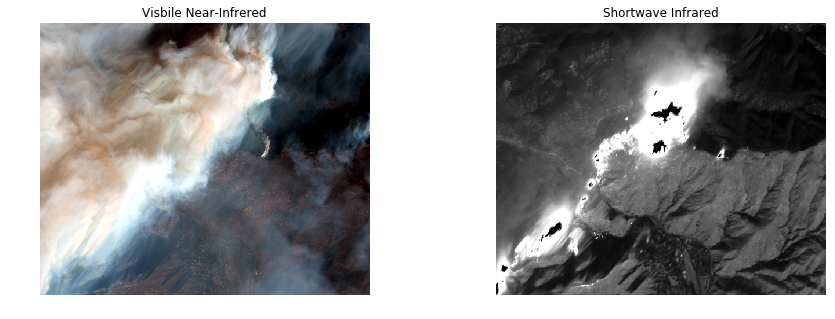

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import box
import numpy as np

plt.figure(figsize=(15,5))

titles = ['Visbile Near-Infrered', 'Shortwave Infrared']

bbox = box(-119.3187, 34.4768, -119.2758, 34.506).bounds

for idx, img in enumerate([vnir.aoi(bbox=bbox).rgb(), swir.aoi(bbox=bbox)[7,:,:]]):
    plt.subplot(1,2,idx+1)
    plt.axis('off')
    plt.imshow(img, cmap="Greys_r")
    plt.title(titles[idx])
    
plt.show()

We can see that VNIR channels are completely blocked by the smoke from an active fire, but the SWIR data are able to penetrate the smoke and see intense fires burning beneath. 

## Exploring the SWIR bands

The SWIR provides us an extremely useful tool for fire detection by being able to penetrate thick smoke. The SWIR captures different wavelengths of data as well some are more useful for fires than others. For instance the first band doesnt see through smoke as effective as the last band. 

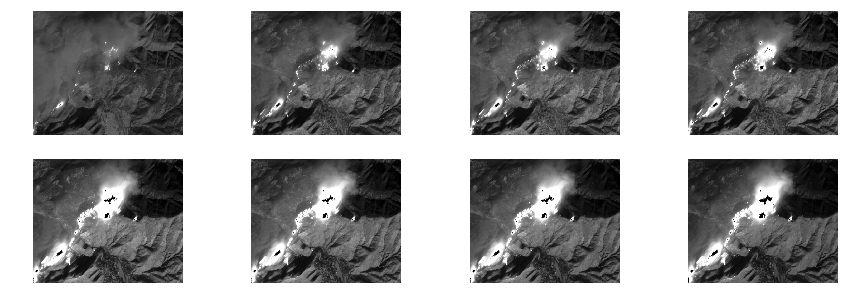

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,5))

for i in range(swir.shape[0]):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    b = swir.aoi(bbox=bbox)[i,:,:]
    plt.imshow(b, cmap="Greys_r")
plt.show()

## Detecting Active Fire Area

The next step in our analysis is to extract the total area of active fires in square kilometers for not just the small AOI but the entire image. To do this we'll use the 4th SWIR band and a threshold value. Pixels found above the threshold will be counted as active fire, and those below will be ignored. 

In [5]:
from collections import Counter
import numpy as np

band = swir[3,:,:].read(quiet=True)

# meters per pixel
mpp = swir.metadata['image']['groundSampleDistanceMeters']

# n-pixels above a threshold
px = np.count_nonzero(band >= .75)

# total area in sq km
sqkm = (mpp * px) / 1000
print '{} sq. km.'.format(sqkm) 

132899.168325 sq. km.


## Extract GeoJSON

To fully exploring the data we want to extract the detected fires as geojson. Using the same threshold value we can define a mask and leverage `rasterio.features` to vectorize the imagery and extract features as geojson. Then we can save the geojson to disk for use elsewhere, and visualize all the fires on an interactive map.

In [6]:
from shapely.ops import transform
from shapely.geometry import shape
from rasterio import features
from functools import partial
import json
import pyproj

reproj = partial(pyproj.transform, pyproj.Proj(init="EPSG:3857"), pyproj.Proj(init="EPSG:4326"))
band = swir[3,:,:].read(quiet=True)

thresh = .75
band[band >= thresh] = 1.0
band[band < thresh] = 0.0
mask = band != 1.0

shapes = features.shapes(band, mask=mask, transform=swir.aoi(bbox=bbox).affine)
geoms = [transform(reproj, shape(g)).__geo_interface__ for g, v in shapes]
print len(geoms), 'features found'

geojson = {"type": "FetureCollection", "features": []}

for idx, geom in enumerate(geoms):
    g = {
        "type": "Feature",
        "geometry": geom,
        "properties": {"id": idx+1}
    }
    geojson['features'].append(g)

fname = 'fires.geojson'
with open(fname, 'w') as fh:
    json.dump(geojson, fh)
    
print 'saved features to {}'.format(fname)

1459 features found
saved features to fires.geojson


In [7]:
gbdx.vectors.map(features=geojson['features'], zoom=11)

<IPython.core.display.Javascript object>